# ECBM E4070 Project 1 [C-Ring Simulations]

    Name: Suheyla Tozan, Vanshika Sriram, Ivan Rivera
    Uni: stt2126, vs2668, ier2112

To run the code just restart the kernel and run all cells

In [1]:
%matplotlib inline

In [2]:
import math
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy import signal
from scipy.ndimage import gaussian_filter

random.seed(0)

In [3]:
#function for generating all kinds of input (i-iv)
def generate_input(bar_width=1, width=8, height=3, steps=100, direction='none', 
                   shape='static', speed=1, amplitude=0.75, intensity=3):
    
    ''' Create vertical bar stimulus 

    Parameters
    ----------
    bar_width: int
        width of the moving bar
    width: int
        width of the whole window, corresponds to the size of one neuronal wedge
    height: int
        height of the whole window
    steps: int
        number of steps to generated the input
    direction: str
        - 'left': bar moves left from the right edge
        - 'right': bar moves right from the left edge
    speed: int
        speed at which bar is moving
    amplitude: float
        amplitude/intensity of the bar
    intensity: float/int
        
    
    Returns
    -------
    X: np.ndarray of shape (height, width, steps)
        The height and width dimensions are flipped as per convention for images
        Index a frame of the image at time index t as `X[..., t]`
    '''
    
    if shape in ['static', 'interval', 'double']:
        assert direction == 'none', \
            "direction should be 'none', got {} instead".format(direction)
    elif shape in ['moving']:
        assert direction in ['left', 'right', 'none'], \
            "direction should be 'left' or 'right', got {} instead".format(direction)
    else:
        assert shape in ['static', 'interval', 'double', 'moving', 'unilateral'], \
            "movement should be 'static', 'interval', 'double', 'moving', or \
            'unilateral', got {} instead".format(shape)

    X = np.zeros((height,width,steps)) #should width be 7 or 8? i think it should be 8 if 1 represents width of wedge
    position = random.randint(1, width) #should width be inclusive or exclusive?

    if shape == 'moving':
        for i in range(steps):                
            x = int(np.floor(width * (i+np.ceil(steps/width)) * speed / steps))
            xmin = int(np.max((0, x-bar_width)))
            if xmin > X.shape[1]:
                # flew off the screen
                break
            X[:,xmin:x,i] = amplitude
        
        # not necessary
        if direction == 'left':
            return X[...,::-1]
        return X
    
    elif shape == 'static':     
        for i in range(steps):
            x = int(np.max((0, position-bar_width)))
            X[:,x:position,:] = amplitude
        return X
    
    elif shape == 'interval':   
        for i in range(steps):
            x = int(np.max((0, position-bar_width)))
            if i<50:
                X[:,x:position,i] = amplitude
            else:
                X[:,x:position,i] = 0   
        return X
    
    elif shape == 'double':
        bar1 = 3#random.randint(0,int(width/2))
        bar2 = 7#random.randint(int(width/2),width)
        for i in range(steps):
            x1 = int(np.max((0, bar1-bar_width)))
            x2 = int(np.max((0, bar2-bar_width)))
            X[:,bar1,i] = amplitude
            X[:,bar2,i] = amplitude/intensity
            
    elif shape == 'unilateral':
        position = 2
        for i in range(steps):
            X[:,position,:] = amplitude
            
    return X

In [4]:
#function for converting bar input to current
def ext_current(bar):
    height, width, steps = bar.shape
    current = np.zeros((width,steps))
    #for h in range(height):
    for w in range(width):
        current[w,:] = bar[0,w,:]
        #if bar[0,w,0] != 0.0:
            #current[w,:] = np.ones(steps)
        #setting current equal to the fluctuations in one pixel over time frames for each wedge, w
        #i think this wont work because iterating through height as well, should h b 1, 
        #since uniform bar over a certain height?
     

    #if moving bar doesnt shift to new position, then current wont shift
    
    
    return current

# C RING MODEL

In [5]:
#generating all inputs
static_bar = generate_input(shape = 'static')
interval_bar = generate_input(shape = 'interval')
moving_bar = generate_input(shape = 'moving', direction = 'right')
double_bar = generate_input(shape = 'double')

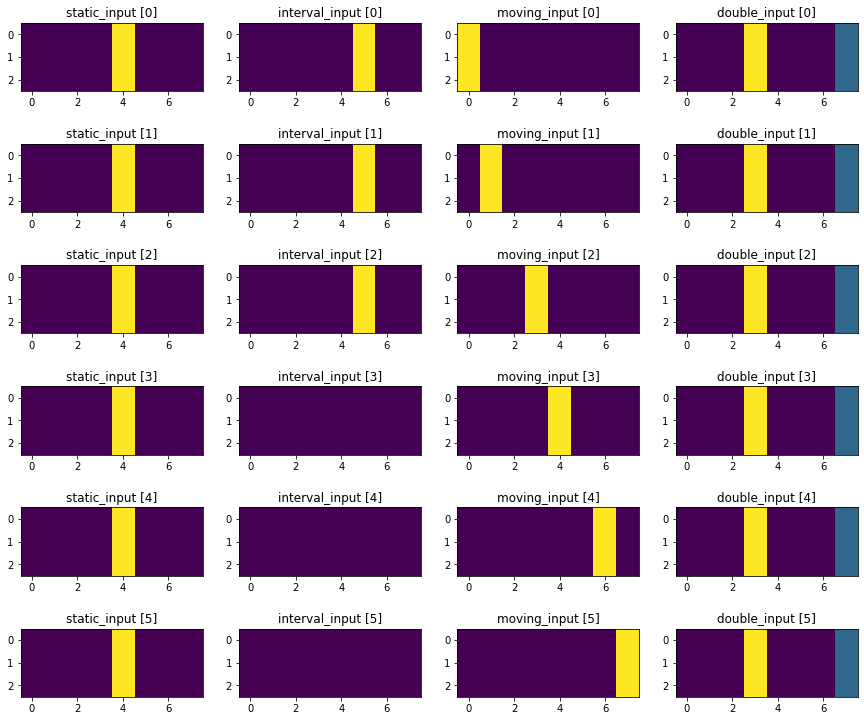

In [6]:
#unpacking all inputs and preparing to show them for visual aid
height, width, time_steps = static_bar.shape #all have same size

steps = time_steps/5
frame_intervals = [0,steps*1,steps*2,steps*3,steps*4,(steps*5)-1]
static_input = [0,0,0,0,0,0]
interval_input = [0,0,0,0,0,0]
moving_input = [0,0,0,0,0,0]
double_input = [0,0,0,0,0,0]
idx = 0

for i in range(time_steps):
    if i in frame_intervals:
        static_input[idx] = static_bar[:,:,i]
        interval_input[idx] = interval_bar[:,:,i]
        moving_input[idx] = moving_bar[:,:,i]
        double_input[idx] = double_bar[:,:,i]
        idx+=1
    
rows = 6
columns = 4
fig, axes = plt.subplots(rows, columns, figsize=(15,13))


for i in range(rows):
    ax1, ax2, ax3, ax4 = axes[i]
    ax1.imshow(static_input[i], )#cmap = "Accent_r")
    ax1.set_title('static_input [{}]'.format(i))
    ax2.imshow(interval_input[i], )#cmap = "Accent_r")
    ax2.set_title('interval_input [{}]'.format(i))
    ax3.imshow(moving_input[i], )#cmap = "Accent_r")
    ax3.set_title('moving_input [{}]'.format(i))
    ax4.imshow(double_input[i], )#cmap = "Accent_r")
    ax4.set_title('double_input [{}]'.format(i))

plt.show()

In [7]:
static_current = ext_current(static_bar)
interval_current = ext_current(interval_bar)
moving_current = ext_current(moving_bar)
double_current = ext_current(double_bar)

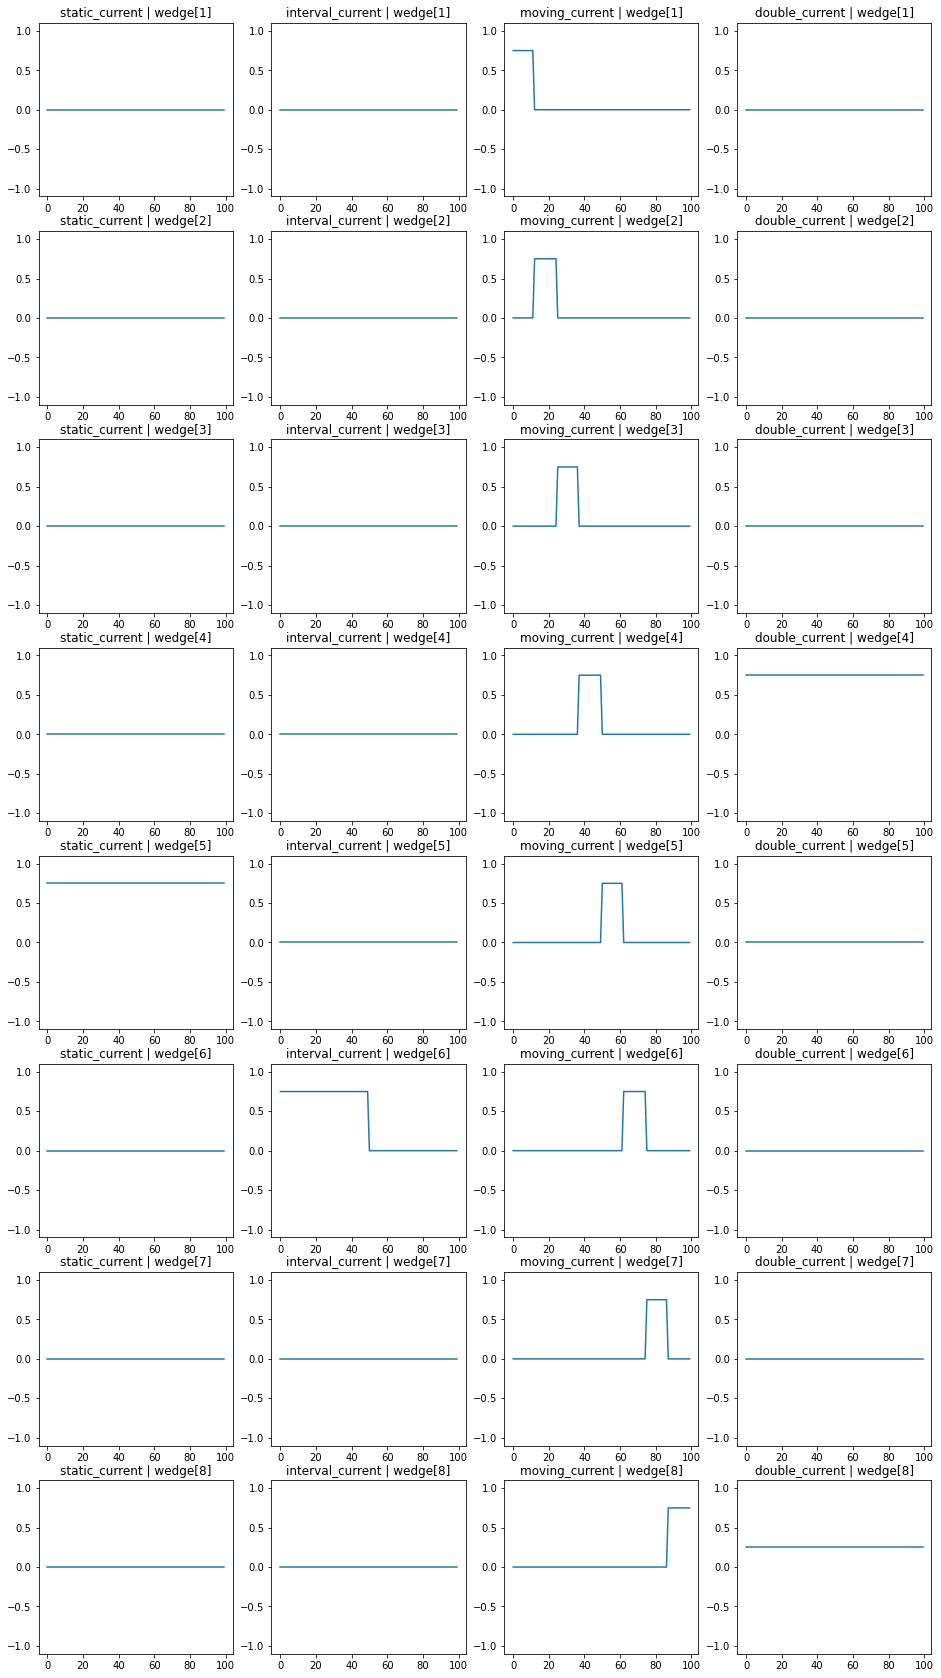

In [8]:
rows = 8
columns = 4
fig, axes = plt.subplots(rows, columns, figsize=(16,30))
horizontal = np.arange(0,time_steps,1)

for i in range(rows):
    ax1, ax2, ax3, ax4 = axes[i]
    ax1.plot(horizontal, static_current[i])
    ax1.set_title('static_current | wedge[{}]'.format(i+1))
    ax1.set_ylim(-1.10,1.10)
    ax2.plot(horizontal, interval_current[i])
    ax2.set_title('interval_current | wedge[{}]'.format(i+1))
    ax2.set_ylim(-1.10,1.10)
    ax3.plot(horizontal, moving_current[i])
    ax3.set_title('moving_current | wedge[{}]'.format(i+1))
    ax3.set_ylim(-1.10,1.10)
    ax4.plot(horizontal, double_current[i])
    ax4.set_title('double_current | wedge[{}]'.format(i+1))
    ax4.set_ylim(-1.10,1.10)

plt.show()

    implementing c ring functions and associated synaptic current, firing rate and ring neuron manipulations

In [9]:
def synaptic_current(n, beta): # n = firing rate value
    return n*beta

def ceiling(x): #x = value
    if x < 0:
        return 0
    elif 0 <= x < 1:
        return x
    else:
        return 1

def firing_rate(firing_prev, net_current, ring_sum=0, ntype="EIP"):
    summation = 0
    alpha = 0.1
    if ntype == "PEI": #red
        for n in range(len(net_current)):
            summation += net_current[n] #summing synaptic currents of EIP
    elif ntype == "EIP": #green
        for n in range(len(net_current)):
            if n == 0 or n == 1: #summing synaptic currents of PEI
                summation += net_current[n]
        summation += ring_sum
    return ceiling(alpha*firing_prev + summation)

def ring_neuron(firing_at_step, beta_ringtog):
    width, neuron = firing_at_step.shape
    summation = 0
    alpha = 0.1
    
    for w in range(width):
        for n in range(neuron):
            if n == 2 or n == 3:
                summation += firing_at_step[w,n]
                       
    return synaptic_current(summation, beta_ringtog)


In [10]:
#neurons - holds firing rate value 
def run_c_ring(bar_input, beta_gtor=0.6, beta_rtog=0.9, beta_ringtog=0.5, neuron_types=4):
    
    height, width, time_steps = bar_input.shape
    
    external_current = ext_current(bar_input)
    firing = np.zeros((time_steps, width, neuron_types)) #0-1 are red, 2-3 are green
    net_current = np.zeros((time_steps, width, neuron_types))

    #firing rate and synaptic current
    for t in range(time_steps): #for all time
        for w in range(width): #for all wedges
            for n in range(neuron_types): #for neuron 
                if n == 0:
                    if t == 0:
                        net_current[t,w,n] = synaptic_current(0, beta_rtog) + external_current[w,t]
                        firing[t,w,n] = firing_rate(0, net_current[t-1,w,:], ntype="PEI")
                        
                        firing[t,w,1] = firing[t,w,n]
                        net_current[t,w,1] = net_current[t,w,n]
                        #this should be okay because the net current for both PEI neurons should be the same

                    elif t != 0: 
                        net_current[t,w,n] = synaptic_current(firing[t-1,w,n], beta_rtog) + external_current[w,t]
                        firing[t,w,n] = firing_rate(firing[t-1,w,n], net_current[t-1,w,:], ntype="PEI")
                        
                        firing[t,w,1] = firing[t,w,n]
                        net_current[t,w,1] = net_current[t,w,n]


                elif n == 2:
                    if t == 0:
                        net_current[t,w,n] = synaptic_current(0, beta_gtor)
                        firing[t,w,n] = firing_rate(0, net_current[t-1,w,:], ntype='EIP')

                        firing[t,w,3] = firing[t,w,n]
                        net_current[t,w,3] = net_current[t,w,n]
                        
                        #ring_sum = synaptic_current(ring_neuron(firing[t,:,:], beta_ringtog), -beta_ringtog)
                        
                    elif t != 0: 
                        
                        net_current[t,w,n] = synaptic_current(firing[t-1,w,n], beta_gtor) + ring_sum
                        firing[t,w,n] = firing_rate(firing[t-1,w,n], net_current[t-1,w,:], ring_sum, ntype="EIP") 
                            
                        firing[t,w,3] = firing[t,w,n]
                        net_current[t,w,3] = net_current[t,w,n]
                        
                        #ring_sum = synaptic_current(ring_neuron(firing[t,:,:], beta_ringtog), -beta_ringtog)

        #defining ring sum for the next step, ring_sum doesn't get rewritten until all 
        #firing rates for EIP neurons have been calculated 
        ring_sum = synaptic_current(ring_neuron(firing[t,:,:], beta_ringtog), -beta_ringtog)
        
    #if neuron is red then net current input = external (current) + synaptic (I)
    #if neuron is green then net current input = synaptic (I)
    #firing rate* beta = synaptic current
    
    #when there is input to the next wedge in the next timestep ie those neurons are firing, 
    #need to prevent firing in the previous wedge at that same timestep
    #there must be a comparison between different wedge activations at each timestep 
    #assuming rightwise activation
    
    return firing, net_current

In [11]:
# visualize activations for  all neurons
def visualize_firing(firing):

    # take 4 time intervals per neuron per wedge (time)

    firing_red_1 = firing[:,:,0]
    firing_red_2 = firing[:,:,1]
    firing_green_1 = firing[:,:,2]
    firing_green_2 = firing[:,:,3]

    rows = 1
    columns = 4
    fig, axes = plt.subplots(rows, columns, figsize=(20,12))

    ax1, ax2, ax3, ax4 = axes
    im1 = ax1.imshow(firing_red_1, aspect=1/10)
    ax1.set_title('firing rate PEI_1')
    fig.colorbar(im1,ax=ax1,fraction=0.050, pad=0.02)
    im2 = ax2.imshow(firing_red_2, aspect=1/10)
    ax2.set_title('firing rate PEI_2')
    fig.colorbar(im2,ax=ax2,fraction=0.050, pad=0.02)
    im3 = ax3.imshow(firing_green_1, aspect=1/10)
    ax3.set_title('firing rate EIP_1')
    fig.colorbar(im3,ax=ax3,fraction=0.050, pad=0.02)
    im4 = ax4.imshow(firing_green_2, aspect=1/10)
    ax4.set_title('firing rate EIP_2')
    fig.colorbar(im4,ax=ax4,fraction=0.050, pad=0.02)

    plt.show()
    

    interval_input: The interval input resembles a bar input for only one wedge of the c ring starts on with maximum amplitude and after some time period shuts off. Because there is no switching between wedges, we expect the firing rate to remain within the same bar and the bump to be maintained even after the input has shut off, which is exactly what we see in the model.


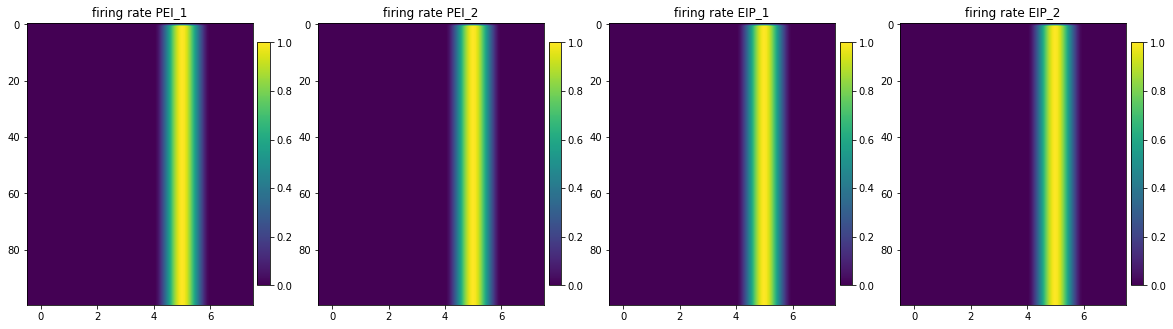

In [12]:
interval_firing, interval_net_current = run_c_ring(interval_bar)
visualize_firing(interval_firing)

    moving_current: When using the moving bar as input, each wedge receives some input as the bar moves. In other words, the external current being received by the PEI neurons of that wedge increases for some time and then decreases as the bar ‘rotates’ around. We expect the R_EIP neuron to inhibit the previous wedge by sending negatively weighted synaptic currents to the EIP neurons once the following wedge is activated. The R_EIP neuron acts like an inhibitory neuron and the sum of the negative synaptic current at the EIP neurons for inactivated wedges results in fast deactivation of the EIP neurons and a delayed deactivation of the PEI neurons.

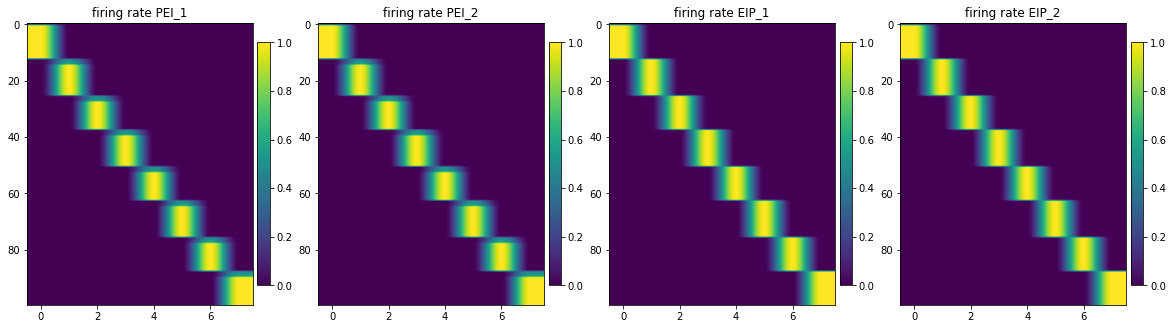

In [13]:
moving_firing, moving_net_current = run_c_ring(moving_bar, beta_gtor = 0.15, beta_rtog = 0.2, beta_ringtog=0.5)
visualize_firing(moving_firing)

    static_current: Using the static bar as input is likely the simplest case. Since only one wedge is activated for all time steps and the activation is constant. The expected bump is one that is sustained for all time frames on the same wedge similar to the interval case and that is what we observe. It is easier to sustain the bump, however, when the input is constant.

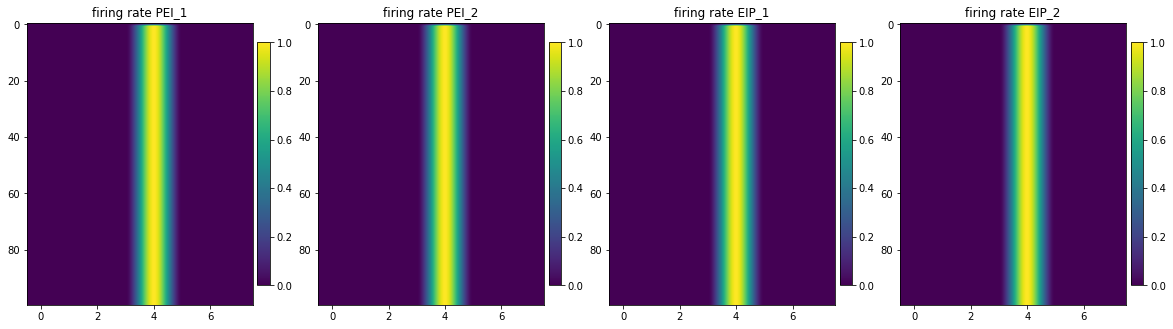

In [14]:
static_firing, static_net_current = run_c_ring(static_bar, beta_gtor = 0.5, beta_rtog = 0.4)
visualize_firing(static_firing)

    double_current (for three relative intensities): Using the double bar as input requires the winner-takes-all characteristic of the R_EIP ring neuron which deactivates the wedge that receives the input with the lowest magnitude. The inhibitory synaptic current received by the EIP neurons from the R_EIP effectively cancels out the lower synaptic currents in the EIP while maintaining the higher amplitude inputs alive which is why only one bar is mostly visible and why a small subsection near early time steps can also be observed. Varying the relative amplitudes of the input bars had no change in the bumps produced, probably because the R_EIP to EIP synaptic weight was large enough to quickly deactivate the weaker bump.

In [15]:
int1_double_bar = generate_input(shape = 'double', amplitude = 0.5, intensity=0.2)
int2_double_bar = generate_input(shape = 'double', intensity=3)
int3_double_bar = generate_input(shape = 'double', intensity=9)

    high intensity for second bar

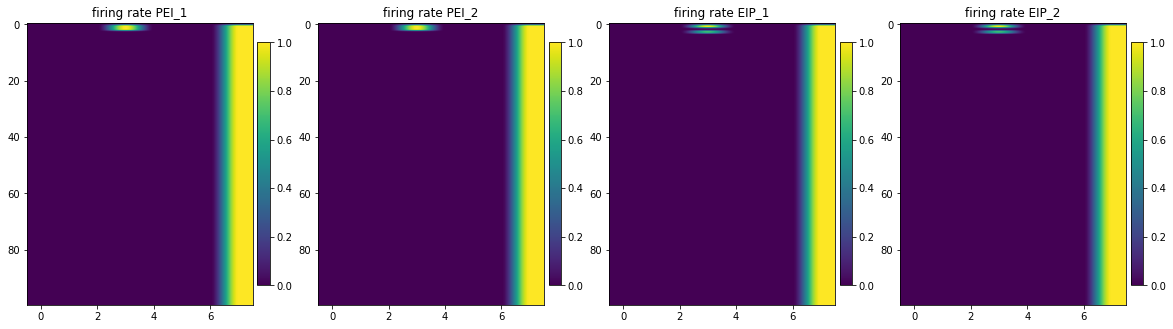

In [16]:
int1_double_firing, int1_double_net_current = run_c_ring(int1_double_bar, beta_gtor = 0.3, beta_rtog = 0.5, beta_ringtog=0.8)
visualize_firing(int1_double_firing)

    low intensity for second bar

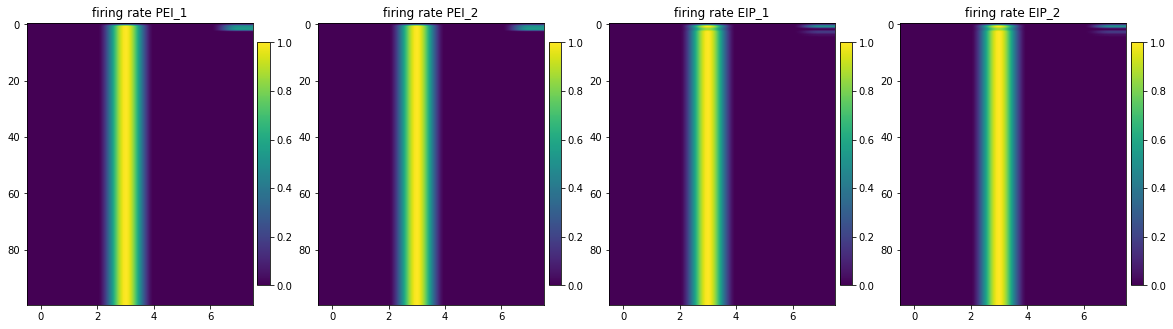

In [17]:
int2_double_firing, int2_double_net_current = run_c_ring(int2_double_bar, beta_gtor = 0.6, beta_rtog = 0.1, beta_ringtog=0.5)
visualize_firing(int2_double_firing)

    even lower intensity for second bar

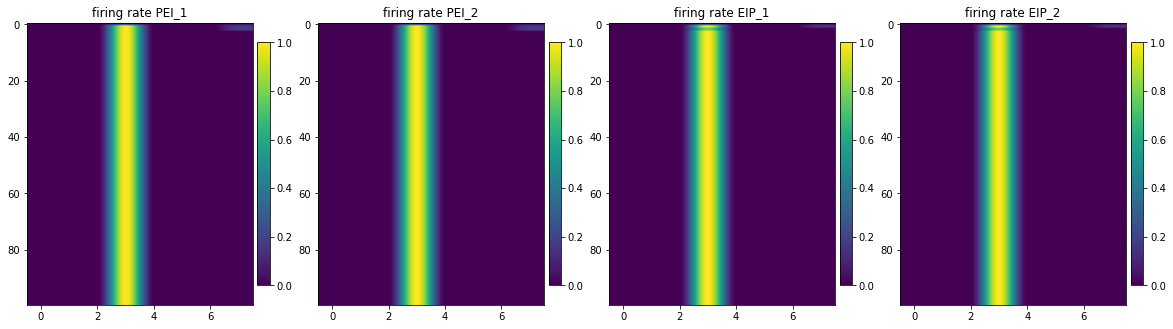

In [18]:
int3_double_firing, int3_double_net_current = run_c_ring(int3_double_bar, beta_gtor = 0.6, beta_rtog = 0.1, beta_ringtog=0.6)
visualize_firing(int3_double_firing)